## libraries

In [127]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import plotly.express as px

from datetime import date

from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline  

import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay,precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
from xgboost import XGBClassifier
# from catboost import CatBoostClassifier

import sklearn.metrics as metrics

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

import pickle
import gzip


### 1. Data Cleaning based on EDA

In [7]:
df = pd.read_csv(r"USA_visadataset.csv")

In [8]:
df.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


##### 1.1 `case_id` column can be dropped as it is an ID.
#### 1.2 `requires_job_training` column can be dropped as it doesn't have much impact on target variable, Proved in visualization and chi2 test.

In [9]:
df_1 = df.drop(columns=["case_id","requires_job_training"])

In [10]:
df_1.head()

,continent,education_of_employee,has_job_experience,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,Asia,High School,N,14513,2007,West,592.2029,Hour,Y,Denied
1,Asia,Master's,Y,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,Asia,Bachelor's,N,44444,2008,West,122996.8600,Year,Y,Denied
3,Asia,Bachelor's,N,98,1897,West,83434.0300,Year,Y,Denied
4,Africa,Master's,Y,1082,2005,South,149907.3900,Year,Y,Certified


#### 1.3  `continent` columns has few unique values with very less count, which can be made as **others**

In [11]:
df_1.continent.value_counts()

continent
Asia             16861
Europe            3732
North America     3292
South America      852
Africa             551
Oceania            192
Name: count, dtype: int64

In [21]:
def make_others_continent(x):
    if x not in ["Asia","Europe","North America"]:
        return "others"
    return x

In [22]:
df_1["continent"] = df_1["continent"].apply(make_others_continent)

In [23]:
df_1.continent.value_counts()

continent
Asia             16861
Europe            3732
North America     3292
others            1595
Name: count, dtype: int64

#### 1.4 `no_of_employees`, `prevailing_wage` columns have outllier which should be handled.

In [24]:
df_1["no_of_employees"].describe() ,  df_1["prevailing_wage"].describe()

(count     25480.000000
 mean       5667.043210
 std       22877.928848
 min         -26.000000
 25%        1022.000000
 50%        2109.000000
 75%        3504.000000
 max      602069.000000
 Name: no_of_employees, dtype: float64,
 count     25480.000000
 mean      74455.814592
 std       52815.942327
 min           2.136700
 25%       34015.480000
 50%       70308.210000
 75%      107735.512500
 max      319210.270000
 Name: prevailing_wage, dtype: float64)

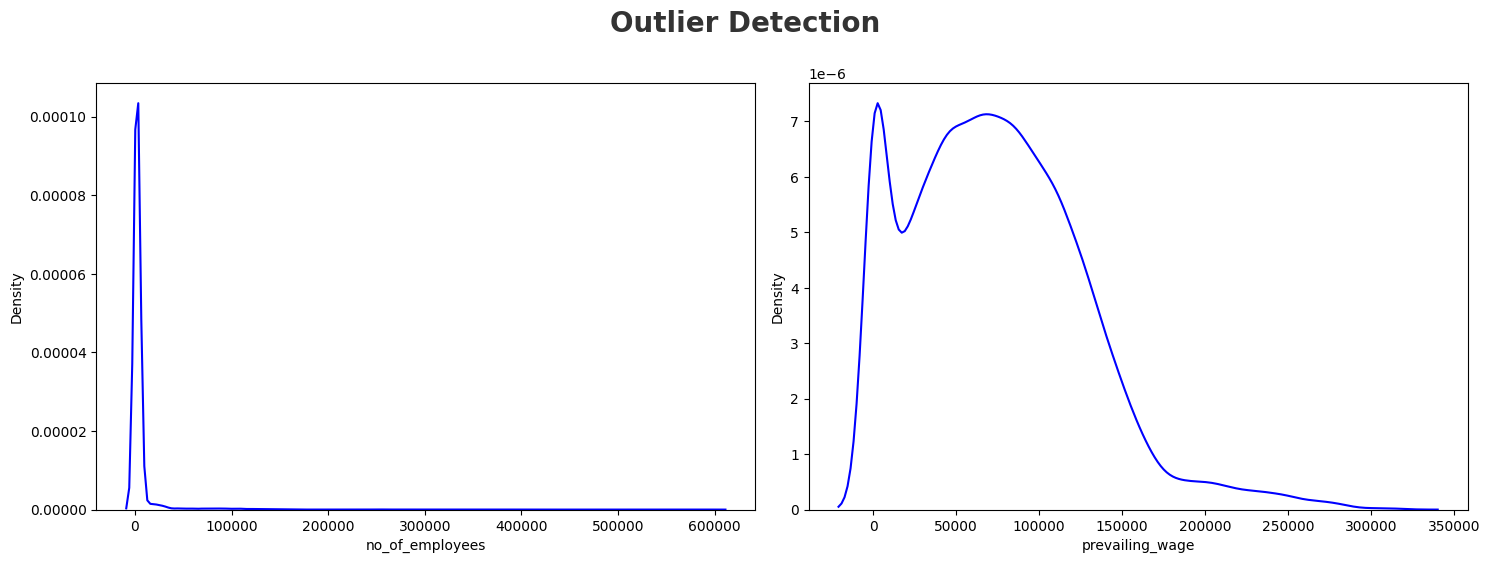

In [25]:
plt.figure(figsize=(15, 10))
plt.suptitle('Outlier Detection', fontsize=20, fontweight='bold', alpha=0.8, y=1.)
numeric_features = ['no_of_employees', 'prevailing_wage']
for i in range(0, len(numeric_features)):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(x=df_1[numeric_features[i]], color='blue')
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

In [29]:
median_75_no_of_employees = 7500.210000
df_2 =  df_1[df_1["no_of_employees"]<7500.210000] # mean_no_of_employees +0*sd_no_of_employees]
mean_prevailing_wage = 74455.814592
sd_prevailing_wage = 52815.942327
df_2 = df_2[df_2["prevailing_wage"]<mean_prevailing_wage+2*sd_prevailing_wage]

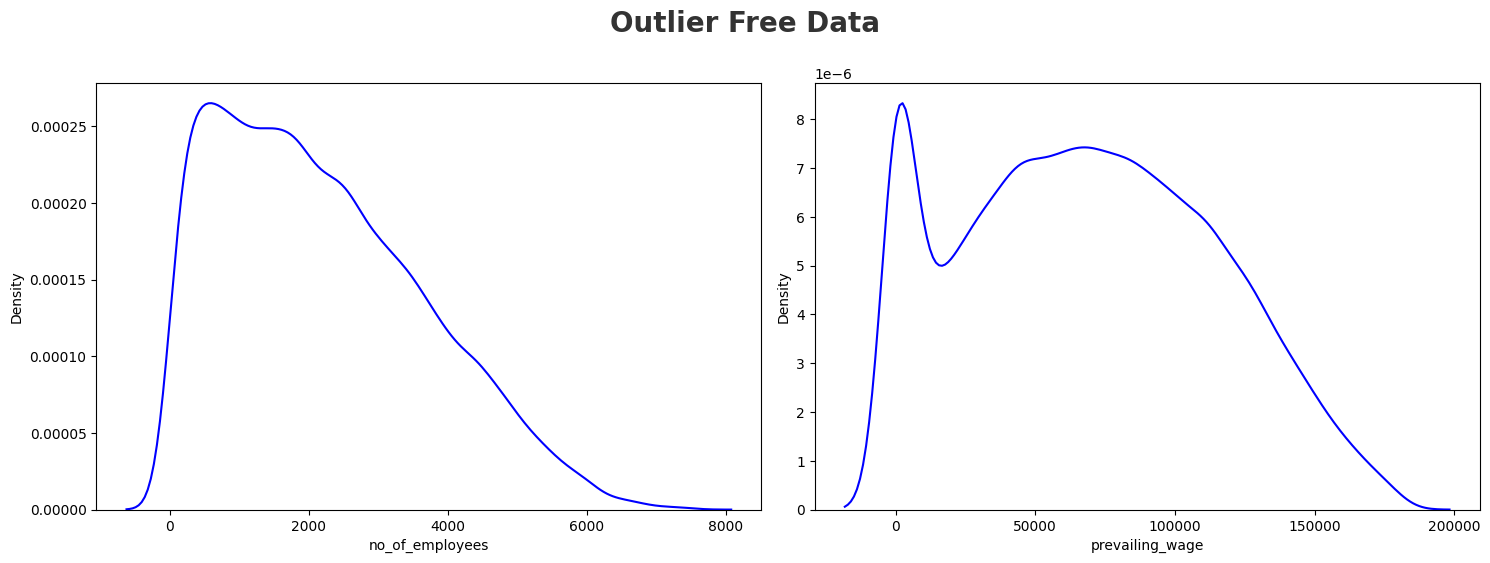

In [30]:
plt.figure(figsize=(15, 10))
plt.suptitle('Outlier Free Data', fontsize=20, fontweight='bold', alpha=0.8, y=1.)
numeric_features = ['no_of_employees', 'prevailing_wage']
for i in range(0, len(numeric_features)):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(x=df_2[numeric_features[i]], color='blue')
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

##### 1.5 Target column `case_status` is imbalanced can be handled before model building.
* will do shuffle at model traning

In [31]:
## 2 Feature Engineering
df_2

,continent,education_of_employee,has_job_experience,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
1,Asia,Master's,Y,2412,2002,Northeast,83425.65,Year,Y,Certified
3,Asia,Bachelor's,N,98,1897,West,83434.03,Year,Y,Denied
4,others,Master's,Y,1082,2005,South,149907.39,Year,Y,Certified
5,Asia,Master's,Y,2339,2012,South,78252.14,Year,Y,Certified
6,Asia,Bachelor's,N,4985,1994,South,53635.39,Year,Y,Certified
...,...,...,...,...,...,...,...,...,...,...
25474,others,Doctorate,N,2594,1979,Northeast,51104.78,Year,Y,Certified
25475,Asia,Bachelor's,Y,2601,2008,South,77092.57,Year,Y,Certified
25477,Asia,Master's,Y,1121,1910,South,146298.85,Year,N,Certified
25478,Asia,Master's,Y,1918,1887,West,86154.77,Year,Y,Certified


In [32]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23088 entries, 1 to 25479
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   continent              23088 non-null  object 
 1   education_of_employee  23088 non-null  object 
 2   has_job_experience     23088 non-null  object 
 3   no_of_employees        23088 non-null  int64  
 4   yr_of_estab            23088 non-null  int64  
 5   region_of_employment   23088 non-null  object 
 6   prevailing_wage        23088 non-null  float64
 7   unit_of_wage           23088 non-null  object 
 8   full_time_position     23088 non-null  object 
 9   case_status            23088 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 1.9+ MB


In [34]:
# creating the date object of today's date
todays_date = date.today()
current_year= todays_date.year

In [37]:
df_2['company_age'] = current_year-df_2['yr_of_estab']
df_2.drop('yr_of_estab', inplace=True, axis=1)
df_2

,continent,education_of_employee,has_job_experience,no_of_employees,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,company_age
1,Asia,Master's,Y,2412,Northeast,83425.65,Year,Y,Certified,23
3,Asia,Bachelor's,N,98,West,83434.03,Year,Y,Denied,128
4,others,Master's,Y,1082,South,149907.39,Year,Y,Certified,20
5,Asia,Master's,Y,2339,South,78252.14,Year,Y,Certified,13
6,Asia,Bachelor's,N,4985,South,53635.39,Year,Y,Certified,31
...,...,...,...,...,...,...,...,...,...,...
25474,others,Doctorate,N,2594,Northeast,51104.78,Year,Y,Certified,46
25475,Asia,Bachelor's,Y,2601,South,77092.57,Year,Y,Certified,17
25477,Asia,Master's,Y,1121,South,146298.85,Year,N,Certified,115
25478,Asia,Master's,Y,1918,West,86154.77,Year,Y,Certified,138


#### 2.1 Doing Label encoding on Catagorical values

In [38]:
# Changing 2 variable catagory first 
def no_yes(x):
    if x=="Y" or x=="Certified" :
        return 1
    return 0

In [39]:
df_3 = df_2.copy()

In [40]:
df_3["has_job_experience"] = df_3["has_job_experience"].apply(no_yes)
df_3["full_time_position"] = df_3["full_time_position"].apply(no_yes)
df_3["case_status"] = df_3["case_status"].apply(no_yes)

In [41]:
df_3

,continent,education_of_employee,has_job_experience,no_of_employees,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,company_age
1,Asia,Master's,1,2412,Northeast,83425.65,Year,1,1,23
3,Asia,Bachelor's,0,98,West,83434.03,Year,1,0,128
4,others,Master's,1,1082,South,149907.39,Year,1,1,20
5,Asia,Master's,1,2339,South,78252.14,Year,1,1,13
6,Asia,Bachelor's,0,4985,South,53635.39,Year,1,1,31
...,...,...,...,...,...,...,...,...,...,...
25474,others,Doctorate,0,2594,Northeast,51104.78,Year,1,1,46
25475,Asia,Bachelor's,1,2601,South,77092.57,Year,1,1,17
25477,Asia,Master's,1,1121,South,146298.85,Year,0,1,115
25478,Asia,Master's,1,1918,West,86154.77,Year,1,1,138


In [47]:
df_3 = df_3.reset_index().drop(columns = ["index"])
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23088 entries, 0 to 23087
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   continent              23088 non-null  object 
 1   education_of_employee  23088 non-null  object 
 2   has_job_experience     23088 non-null  int64  
 3   no_of_employees        23088 non-null  int64  
 4   region_of_employment   23088 non-null  object 
 5   prevailing_wage        23088 non-null  float64
 6   unit_of_wage           23088 non-null  object 
 7   full_time_position     23088 non-null  int64  
 8   case_status            23088 non-null  int64  
 9   company_age            23088 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 1.8+ MB


In [48]:
# categorical_features,numeric_features
categorical_features = [feature for feature in df_3.columns if df_3[feature].dtype == 'O']
numeric_features = [feature for feature in df_3.columns if df_3[feature].dtype != "O"]

In [54]:
coder = OneHotEncoder()

encoded_data = coder.fit_transform(df_3[categorical_features])
# encoded_data = pd.DataFrame(encoded_data.toarray())
len(encoded_data.toarray())

23088

In [55]:
df_4 = df_3.join(pd.DataFrame(encoded_data.toarray()))
df_4

,continent,education_of_employee,has_job_experience,no_of_employees,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,company_age,...,7,8,9,10,11,12,13,14,15,16
0,Asia,Master's,1,2412,Northeast,83425.65,Year,1,1,23,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Asia,Bachelor's,0,98,West,83434.03,Year,1,0,128,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,others,Master's,1,1082,South,149907.39,Year,1,1,20,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,Asia,Master's,1,2339,South,78252.14,Year,1,1,13,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,Asia,Bachelor's,0,4985,South,53635.39,Year,1,1,31,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23083,others,Doctorate,0,2594,Northeast,51104.78,Year,1,1,46,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
23084,Asia,Bachelor's,1,2601,South,77092.57,Year,1,1,17,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
23085,Asia,Master's,1,1121,South,146298.85,Year,0,1,115,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
23086,Asia,Master's,1,1918,West,86154.77,Year,1,1,138,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [56]:
print("Basically Classes are : ")
coder.categories_

Basically Classes are : 


[array(['Asia', 'Europe', 'North America', 'others'], dtype=object),
 array(["Bachelor's", 'Doctorate', 'High School', "Master's"], dtype=object),
 array(['Island', 'Midwest', 'Northeast', 'South', 'West'], dtype=object),
 array(['Hour', 'Month', 'Week', 'Year'], dtype=object)]

In [57]:
columnsname = {0:'Asia',1: 'Europe',2: 'North America',3:"others", 4:"Bachelor's",5: 'Doctorate',6:"High School",7:"Master's",
              8:'Island', 9:'Midwest',10: 'Northeast',11: 'South', 12:'West',13:'Hour', 14:'Month',15: 'Week', 16:'Year' }
df_6 = df_4.drop(columns=["education_of_employee","continent","region_of_employment","unit_of_wage"])
df_6 =df_6.rename(columns=columnsname)

In [58]:
df_6.head()

,has_job_experience,no_of_employees,prevailing_wage,full_time_position,case_status,company_age,Asia,Europe,North America,others,...,Master's,Island,Midwest,Northeast,South,West,Hour,Month,Week,Year
0,1,2412,83425.65,1,1,23,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,98,83434.03,1,0,128,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1,1082,149907.39,1,1,20,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1,2339,78252.14,1,1,13,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0,4985,53635.39,1,1,31,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Split X and Y
- Split Dataframe to X and y
- Here we set a variable X i.e, independent columns, and a variable y i.e, dependent column as the “ProdTaken” column.

In [59]:
df_6.columns

Index(['has_job_experience', 'no_of_employees', 'prevailing_wage',
       'full_time_position', 'case_status', 'company_age', 'Asia', 'Europe',
       'North America', 'others', 'Bachelor's', 'Doctorate', 'High School',
       'Master's', 'Island', 'Midwest', 'Northeast', 'South', 'West', 'Hour',
       'Month', 'Week', 'Year'],
      dtype='object')

In [60]:
X  = df_6.drop(columns=["case_status"])
y = df_6["case_status"]

In [61]:
X = X.iloc[:,:8]

## Feature Transformation

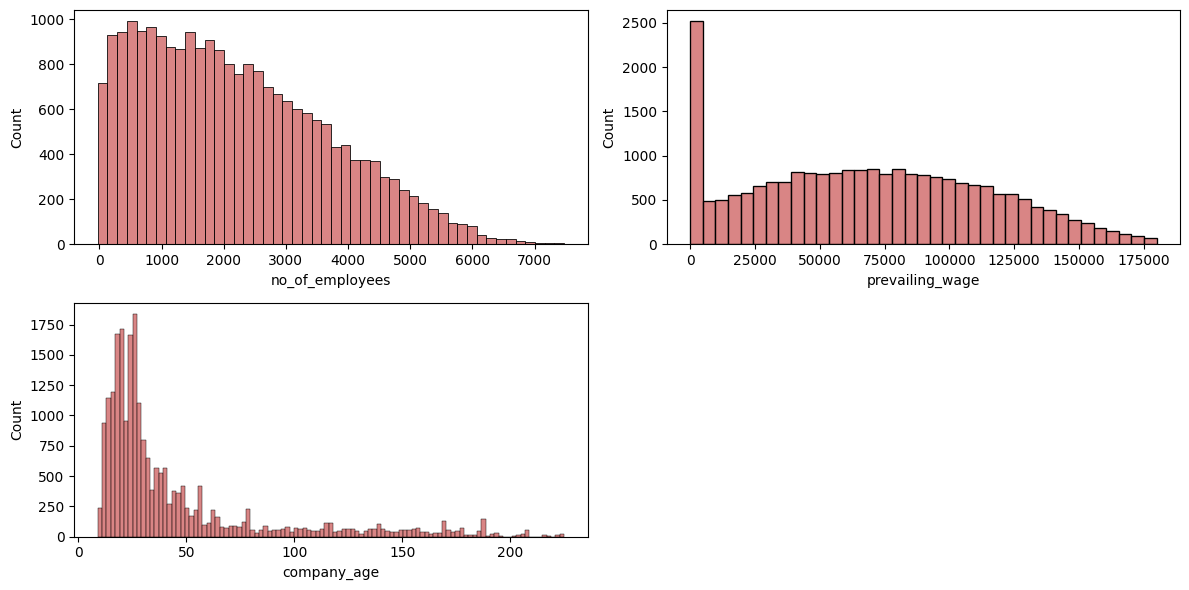

In [62]:
# distribution of data before scaling
plt.figure(figsize=(12, 6))
for i, col in enumerate(['no_of_employees','prevailing_wage','company_age']):
    plt.subplot(2, 2, i+1)
    sns.histplot(x=X[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

In [63]:
X[['no_of_employees','prevailing_wage','company_age']].skew(axis=0, skipna=True)

no_of_employees    0.589112
prevailing_wage    0.178977
company_age        2.042325
dtype: float64

- Positiviely Skewed : company_age, no_of_employees

### Positiviely Skewed : company_age, no_of_employees

In [64]:
num_features = list(X.select_dtypes(exclude="object").columns)

In [65]:
num_features

['has_job_experience',
 'no_of_employees',
 'prevailing_wage',
 'full_time_position',
 'company_age',
 'Asia',
 'Europe',
 'North America']

In [66]:
num_features = ['has_job_experience',
 'no_of_employees',
 'prevailing_wage',
 'full_time_position',
 'company_age',
 'Asia',
 'Europe',
 'North America',
 'others',
 "Bachelor's",
 'Doctorate',
 'High School',
 "Master's",
 'Island',
 'Midwest',
 'Northeast',
 'South',
 'West',
 'Hour',
 'Month',
 'Week',
 'Year']
or_columns = ['has_job_experience','full_time_position']
transform_columns= ['no_of_employees','company_age']
num_features = ['has_job_experience',
 'no_of_employees',
 'prevailing_wage',
 'full_time_position',
 'company_age',
 'Asia',
 'Europe',
 'North America']

In [67]:
X

,has_job_experience,no_of_employees,prevailing_wage,full_time_position,company_age,Asia,Europe,North America
0,1,2412,83425.65,1,23,1.0,0.0,0.0
1,0,98,83434.03,1,128,1.0,0.0,0.0
2,1,1082,149907.39,1,20,0.0,0.0,0.0
3,1,2339,78252.14,1,13,1.0,0.0,0.0
4,0,4985,53635.39,1,31,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
23083,0,2594,51104.78,1,46,0.0,0.0,0.0
23084,1,2601,77092.57,1,17,1.0,0.0,0.0
23085,1,1121,146298.85,0,115,1.0,0.0,0.0
23086,1,1918,86154.77,1,138,1.0,0.0,0.0


In [136]:
# Identify categorical and numerical features

X  = df_2.drop(columns=["case_status"])
y = df_3["case_status"]

categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Display the results
print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

Categorical Features: ['continent', 'education_of_employee', 'has_job_experience', 'region_of_employment', 'unit_of_wage', 'full_time_position']
Numerical Features: ['no_of_employees', 'prevailing_wage', 'company_age']


In [137]:
numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

transform_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('transformer', PowerTransformer())
])

preprocessor = ColumnTransformer(
    [
        ("On_Hot_Encoder", oh_transformer, categorical_features),
        ("StandardScaler", numeric_transformer, numerical_features)
    ]
)

In [138]:
preprocessor

,transformers,"[('On_Hot_Encoder', ...), ('StandardScaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,None
,sparse_output,True


In [139]:
preprocessor.fit_transform(X)

array([[ 1.        ,  0.        ,  0.        , ...,  0.14581695,
         0.31954955, -0.5313793 ],
       [ 1.        ,  0.        ,  0.        , ..., -1.410018  ,
         0.31973519,  1.95785935],
       [ 0.        ,  0.        ,  0.        , ..., -0.74841835,
         1.79225836, -0.60250041],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -0.72219641,
         1.71232169,  1.6496679 ],
       [ 1.        ,  0.        ,  0.        , ..., -0.18632759,
         0.38000524,  2.1949297 ],
       [ 1.        ,  0.        ,  0.        , ...,  0.67227277,
         0.04156886,  0.46431616]])

In [140]:
with open('PII_model.pickle', 'wb') as picklefile:
    pickle.dump(preprocessor, picklefile)

In [76]:
X

,continent,education_of_employee,has_job_experience,no_of_employees,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,company_age
1,Asia,Master's,Y,2412,Northeast,83425.65,Year,Y,23
3,Asia,Bachelor's,N,98,West,83434.03,Year,Y,128
4,others,Master's,Y,1082,South,149907.39,Year,Y,20
5,Asia,Master's,Y,2339,South,78252.14,Year,Y,13
6,Asia,Bachelor's,N,4985,South,53635.39,Year,Y,31
...,...,...,...,...,...,...,...,...,...
25474,others,Doctorate,N,2594,Northeast,51104.78,Year,Y,46
25475,Asia,Bachelor's,Y,2601,South,77092.57,Year,Y,17
25477,Asia,Master's,Y,1121,South,146298.85,Year,N,115
25478,Asia,Master's,Y,1918,West,86154.77,Year,Y,138


In [78]:
X = preprocessor.fit_transform(X)

In [79]:
# Get the transformed feature names
feature_names = preprocessor.get_feature_names_out()

In [80]:
feature_names

array(['On_Hot_Encoder__continent_Asia',
       'On_Hot_Encoder__continent_Europe',
       'On_Hot_Encoder__continent_North America',
       'On_Hot_Encoder__continent_others',
       "On_Hot_Encoder__education_of_employee_Bachelor's",
       'On_Hot_Encoder__education_of_employee_Doctorate',
       'On_Hot_Encoder__education_of_employee_High School',
       "On_Hot_Encoder__education_of_employee_Master's",
       'On_Hot_Encoder__has_job_experience_N',
       'On_Hot_Encoder__has_job_experience_Y',
       'On_Hot_Encoder__region_of_employment_Island',
       'On_Hot_Encoder__region_of_employment_Midwest',
       'On_Hot_Encoder__region_of_employment_Northeast',
       'On_Hot_Encoder__region_of_employment_South',
       'On_Hot_Encoder__region_of_employment_West',
       'On_Hot_Encoder__unit_of_wage_Hour',
       'On_Hot_Encoder__unit_of_wage_Month',
       'On_Hot_Encoder__unit_of_wage_Week',
       'On_Hot_Encoder__unit_of_wage_Year',
       'On_Hot_Encoder__full_time_position_N',


In [81]:
X

array([[ 1.        ,  0.        ,  0.        , ...,  0.14581695,
         0.31954955, -0.5313793 ],
       [ 1.        ,  0.        ,  0.        , ..., -1.410018  ,
         0.31973519,  1.95785935],
       [ 0.        ,  0.        ,  0.        , ..., -0.74841835,
         1.79225836, -0.60250041],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -0.72219641,
         1.71232169,  1.6496679 ],
       [ 1.        ,  0.        ,  0.        , ..., -0.18632759,
         0.38000524,  2.1949297 ],
       [ 1.        ,  0.        ,  0.        , ...,  0.67227277,
         0.04156886,  0.46431616]])

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21,stratify=y)

# Define scaling methods
scaling_methods = {
    'StandardScaler': StandardScaler()
    #, 'RobustScaler': RobustScaler()
}

models = {
    'SVM': (SVC(), {'classifier__C': [0.1, 1], 'classifier__kernel': ['linear', 'rbf']}),
    'RandomForest': (RandomForestClassifier(), {'classifier__n_estimators': [50, 100], 'classifier__max_depth': [10, 20]}),
    "AdaBoostClassifier":(AdaBoostClassifier(),{})
}

results = {}
for scaler_name, scaler in scaling_methods.items():
    for model_name, (model, param_grid) in models.items():
        pipeline = Pipeline([
            ('scaler', scaler),
            ('classifier', model)
        ])
        
        # Perform grid search cross-validation
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        # Store best cross-validation score
        results[(scaler_name, model_name)] = grid_search.best_score_

# Display results
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Best Cross-Validation Score'])
print(results_df)

In [85]:
X_train

array([[ 0.        ,  1.        ,  0.        , ..., -1.32059447,
        -0.9524448 , -0.62620744],
       [ 1.        ,  0.        ,  0.        , ...,  0.10009665,
         1.08492916,  0.22724581],
       [ 1.        ,  0.        ,  0.        , ...,  1.81796973,
        -0.13695741, -0.48396523],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -0.56217536,
         0.40923513, -0.50767227],
       [ 0.        ,  0.        ,  1.        , ...,  0.35357538,
         1.07293381, -0.60250041],
       [ 1.        ,  0.        ,  0.        , ...,  0.34954123,
        -1.3746867 ,  0.46431616]])

In [87]:
des_tree  =DecisionTreeClassifier(criterion="gini")
des_tree.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [90]:
des_tree.score(X_test,y_test)

0.6533131225638805

In [91]:
ada_boo = AdaBoostClassifier(learning_rate=0.1)
ada_boo.fit(X_train,y_train)
ada_boo.score(X_test,y_test)

0.6868774361195322

In [95]:
gra_boo = GradientBoostingClassifier(learning_rate=.12)
gra_boo.fit(X_train,y_train)
gra_boo.score(X_test,y_test)

0.7589865742745777

In [96]:
log_rig = LogisticRegression(max_iter=10000)
log_rig.fit(X_train,y_train)
log_rig.score(X_test,y_test)

0.7477262884365526

In [97]:
rad_fr = RandomForestClassifier(max_depth=15)
rad_fr.fit(X_train,y_train)
rad_fr.score(X_test,y_test)

0.7511909917713295

In [101]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTEENN(random_state=42,sampling_strategy='minority' )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X, y)

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((12164, 24), (3041, 24))

In [106]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [107]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
    #  "CatBoosting Classifier": CatBoostClassifier(verbose=False),
     "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()
}

accuracy_list=[]
models_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy, model_train_f1,model_train_precision,\
    model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred) 


    # Test set performance
    model_test_accuracy,model_test_f1,model_test_precision,\
    model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)

    print(list(models.keys())[i])
    models_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1)) 
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

    
    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
    accuracy_list.append(model_test_accuracy)


    print('='*35)
    print('\n')

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9536
- F1 score: 0.9502
- Precision: 0.9526
- Recall: 0.9479
- Roc Auc Score: 0.9533


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9214
- F1 score: 0.9151
- Precision: 0.9233
- Recall: 0.9070
- Roc Auc Score: 0.9205


Gradient Boosting
Model performance for Training set
- Accuracy: 0.8973
- F1 score: 0.8915
- Precision: 0.8769
- Recall: 0.9065
- Roc Auc Score: 0.8979
----------------------------------
Model performance for Test set
- Accuracy: 0.8796
- F1 score: 0.8736
- Precision: 0.8570
- Recall: 0.8908
- Roc Auc Score: 0.8803


Logistic Regression
Model performance for Training 

In [109]:
# calculate the fpr and tpr for all thresholds of the classification
def make_Roc_curve(model):
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    # method I: plt
    import matplotlib.pyplot as plt
    plt.title(f'{model}')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

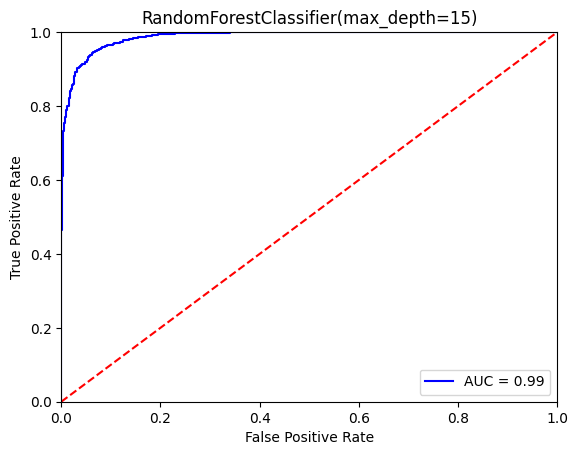

In [110]:
make_Roc_curve(rad_fr)

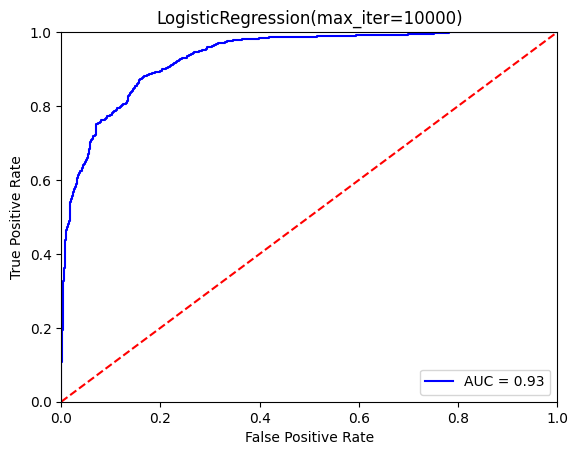

In [112]:
make_Roc_curve(log_rig)

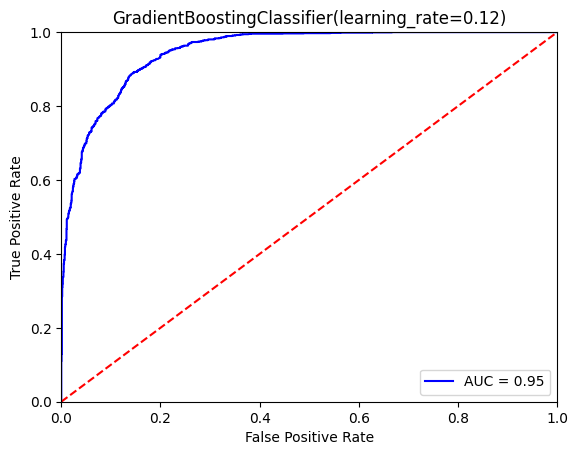

In [113]:
make_Roc_curve(gra_boo)

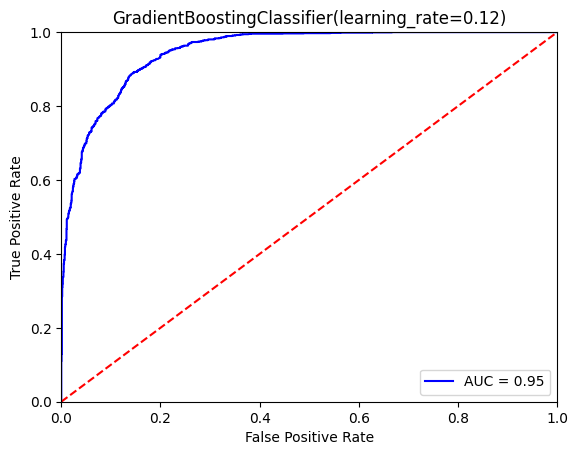

In [114]:
make_Roc_curve(gra_boo)

In [115]:
Results = pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Accuracy_score'])
Results.sort_values(by=["Accuracy_score"],ascending=False)

,Model Name,Accuracy_score
0,Random Forest,0.953634
4,K-Neighbors Classifier,0.936534
5,XGBClassifier,0.927327
1,Decision Tree,0.921407
6,Support Vector Classifier,0.883591
2,Gradient Boosting,0.879645
7,AdaBoost Classifier,0.857941
3,Logistic Regression,0.851694


In [118]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
criterion = ["gini", "entropy", "log_loss"]
# Create the random grid
rf_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion}

In [121]:
random = RandomizedSearchCV(estimator=RandomForestClassifier(),
                                   param_distributions=rf_params,
                                   n_iter=50,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1)
random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


,estimator,RandomForestClassifier()
,param_distributions,"{'criterion': ['gini', 'entropy', ...], 'max_depth': [10, 20, ...], 'max_features': ['log2', 'sqrt', ...], 'min_samples_leaf': [1, 2, ...], ...}"
,n_iter,50
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [126]:
best_params = random.best_params_
print(best_params)


rf=RandomForestClassifier(**best_params, n_jobs=-1)

# rf=RandomForestClassifier(criterion='entropy', max_depth=90, max_features='log2',n_estimators=800, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


model_test_accuracy,model_test_f1,model_test_precision,model_test_recall,model_test_rocauc_score= evaluate_clf(y_test, y_pred)

print('Model performance for Test set')
print('- Accuracy: {:.4f}'.format(model_test_accuracy))
print('- F1 score: {:.4f}'.format(model_test_f1))
print('- Precision: {:.4f}'.format(model_test_precision))
print('- Recall: {:.4f}'.format(model_test_recall))
print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))

{'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90, 'criterion': 'entropy'}
Model performance for Test set
- Accuracy: 0.9540
- F1 score: 0.9508
- Precision: 0.9488
- Recall: 0.9528
- Roc Auc Score: 0.9539


In [128]:
rf.feature_importances_

array([0.01851653, 0.04246106, 0.01520615, 0.00788986, 0.04043168,
       0.04634049, 0.13332503, 0.07961644, 0.05566694, 0.05915847,
       0.00331121, 0.02235924, 0.01422885, 0.01391829, 0.01577521,
       0.03422542, 0.00090052, 0.00195519, 0.02784314, 0.00829477,
       0.00812778, 0.11420388, 0.13781379, 0.09843007])

In [130]:
importances = rf.feature_importances_

# Create a DataFrame for features and their importances
feature_importance_df = pd.DataFrame({'Feature':feature_names, 'Importance': importances})

# Sort the DataFrame by importance
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Display the top 3 features
print("Top 3 Important Features:")
print(top_features)

Top 3 Important Features:
                                              Feature  Importance
22                    StandardScaler__prevailing_wage    0.137814
6   On_Hot_Encoder__education_of_employee_High School    0.133325
21                    StandardScaler__no_of_employees    0.114204
23                        StandardScaler__company_age    0.098430
7      On_Hot_Encoder__education_of_employee_Master's    0.079616
9                On_Hot_Encoder__has_job_experience_Y    0.059158
8                On_Hot_Encoder__has_job_experience_N    0.055667
5     On_Hot_Encoder__education_of_employee_Doctorate    0.046340
1                    On_Hot_Encoder__continent_Europe    0.042461
4    On_Hot_Encoder__education_of_employee_Bachelor's    0.040432


In [131]:
rf

,n_estimators,1600
,criterion,'entropy'
,max_depth,90
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [132]:
# Save the model using gzip compression
with gzip.open('random_forest_model_compressed.pkl.gz', 'wb') as f:
    pickle.dump(rf, f)

In [133]:
# Save the trained RandomForest model
with open('random_forest_model_final.pkl', 'wb') as f:
    pickle.dump(rf, f)


In [134]:
# Save the best parameters to a file
with open('best_params.pkl', 'wb') as f:
    pickle.dump(best_params, f)


## Best Model is Random Forest with Accuracy 95.40%